# Laplacian Eigenmaps

This notebooks first describes the Laplacian Eigenmaps algorithm for dimensionality reduction and data representation, giving the intuition behind the algorithm (_`Belkin, M., & Niyogi, P. (2003). Laplacian eigenmaps for dimensionality reduction and data representation. Neural computation, 15(6), 1373-1396`_).
Then, this notebook illustrates these results with numerical implementations and shows somes possible applications of Laplacian Eigenmaps for real data.
Finally, this notebook shows some theoretical links between the Laplacian of a graph and the Laplace-Beltrami operator on a manifold.

## The Algorithm

### The idea

Let $x_1, ..., x_n$ be $n$ points in $\mathbb{R}^d$. The objective of this algorithm is, given an integer $k << d$, to construct $y_1, ..., y_n \in \mathbb{R}^k$ such that for all $i = 1, ..., n$, $y_i$ is a good representation of $x_i$. More precisely, one would expect that if $x_i$ and $x_j$ are ''close'' in $\mathbb{R}^d$, their representations $y_i$ and $y_j$ in $\mathbb{R}^k$ should also be close.

Assuming that $x_1, ..., x_n \in \mathcal{M}$, where $\mathcal{M}$ is a manifold of dimension $k$ embedded in $\mathbb{R}^d$, the desired property is equivalent to unfolding the manifold $\mathcal{M}$. The notion of ''closeness'' for $x_1, ..., x_n$ should be the geodesic distance in $\mathcal{M}$ instead of the the usual euclidian distance in $\mathbb{R}^d$.

Mathematically, the optimization problem is :
$$
\min_{y_1, ..., y_n \in \mathbb{R}^k} \sum_{i,j} W_{ij} \, ||y_i - y_j||^2 \quad \quad \quad (1)
$$
where $W_{ij}$ should be big if $x_i$ and $x_j$ are close in $\mathcal{M}$, and $0$ if $x_i$ and $x_j$ are too distant in $\mathcal{M}$, so that points that are close in $\mathcal{M}$ are not too much distorted and points that lie far away in $\mathcal{M}$ do not interfere with the unfolding of $\mathcal{M}$.

As it is clear that the set of solutions of the previous minimization problem is translation and rotation invariant, an additional constraint should be added :
$$
Y D Y^T = I
$$
where $Y = [y_1, ..., y_n] \in \mathbb{R}^{k \times n}$ and $D \in \mathbb{R}^{n \times n}$ is the diagonal matrix with $D_{ii} = \sum_{j} W_{ij}$.

Defining $L = D - W$ the __Laplacian__ of the data, the objective of the minimization can be rewritten :
$$
\begin{align*}
\sum_{i,j=1}^n { W_{ij} ||y_i - y_j||^2 } &&& = && \sum_{i,j=1}^n { W_{ij} \big( ||y_i||_2^2 + ||y_j||_2^2 - 2 \langle y_i \: | \: y_j \rangle \big) } \\
&&& = && 2 \sum_{i,j=1}^n { W_{ij} \big( ||y_i||^2 - \langle y_i \: | \: y_j \rangle \big) } \textrm{ since } W = W^T \\
&&& = && 2 \sum_{i,j=1}^n { D_{ij} ||y_i||^2 - W_{ij} \langle y_i \: | \: y_j \rangle } \\
&&& = && 2 \sum_{i,j=1}^n \sum_{l=1}^k { \Big( D_{ij} Y_{li}^2 - W_{ij} Y_{li} Y_{lj} \Big) } \\
&&& = && 2 \sum_{l=1}^k \sum_{i,j=1}^n { Y_{li} Y_{lj} L_{ij} } \\
&&& = && 2 \: \textrm{Tr} \big( Y L Y^T \big)
\end{align*}
$$

Finally, the optimization to be computed is :
$$
\min_{Y \in \mathbb{R}^{k \times n} \textrm{ st. } YDY^T = I} \textrm{Tr} \big( Y L Y^T \big)
$$

### The algorithm

Let us now describe the Laplacian Eigenmaps algorithm, with a implementation point of view.

* __Step 1 : compute the weights $W_{ij}$__
    * Set $W_{ij} = \exp\left\{-\frac{||x_i - x_j||^2}{t}\right\}$ if $||x_i - x_j|| < \epsilon$ and $W_{ij} = 0$ otherwise
    * Or set $W_{ij} = \exp\left\{-\frac{||x_i - x_j||^2}{t}\right\}$ if $x_i$ is among the $m$ nearest neighbors of $x_j$ or $x_j$ is among the $m$ nearest neighbors of $x_i$, and $W_{ij} = 0$ otherwise

* __Step 2 : compute the minimizer $Y \in \mathbb{R}^{k \times n}$__
    * Find $f_0, ..., f_{n-1} \in \mathbb{R}^n$ such that $ L f_j = \lambda_j D f_j$ for all $j$, with $0 = \lambda_0 \leq ... \leq \lambda_{n-1}$
    * Return $y_i = (f_1(i), ..., f_k(i)) \in \mathbb{R}^k$

### Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import eigh

def LaplacianEigenmaps(X, k=2, m=5, t=0.1):
    '''
    Return the representation of the data X in k dimensions, using the Laplacian Eigenmaps algorithm.
    X : dataset, d x n array
    k : number of dimensions to be kept, integer
    m : number of nearest neighbors to be selected, integer
    t : decay size, positive float or 'infinity'
    
    return Y : k x n array
    '''
    
    assert k < X.shape[0]
    
    # Step 1 : compute the weights
    try:
        if t == 'infinity':
            W = kneighbors_graph(X.T, n_neighbors=m, mode='connectivity', include_self=False)
            W = W.toarray()
        elif t > 0:
            W = kneighbors_graph(X.T, n_neighbors=m, mode='distance', include_self=False)
            W = W.toarray()
            W[W>0] = np.exp(-W[W>0]/t)
        else:
            raise ValueError('Parameter t should either be \'infinity\' or a positive float.')
    except TypeError as err:
        print('Parameter t should either be \'infinity\' or a positive float :', err)
        raise
    
    #Step 2 : solve the generalized eigenvalue problem
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    _, eigvecs = eigh(L, D)
    return(eigvecs[:,1:(k+1)].T)

Let us test the Laplacian Eigenmaps algorithm on a simulated dataset : let us pick uniformly at random $200$ points on a semicircle in $\mathbb{R}^2$, and compute the ''projected'' points on the segment $[0,1]$.
We can see that the algorithm performs very well on this simple and artificial dataset, when the parameters are well chosen : the manifold if perfectly unfolded.

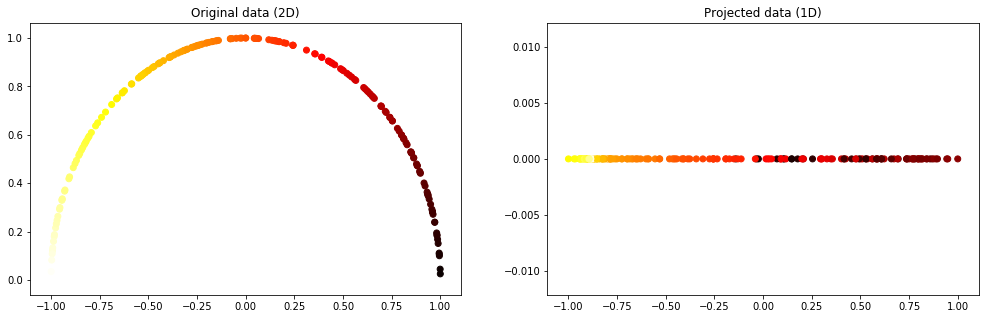

In [8]:
# Number of points
N = 200

# Generate N points uniformly at random on the upper semicircle
X = np.random.randn(2,N)
X[:,X[1,:]<0] *= -1
X /= np.linalg.norm(X, axis=0)

# Compute the angles of the generated points (for plotting colors)
angles = (180/np.pi)*np.arctan(X[1,:]/X[0,:])
angles[angles < 0] = 180 + angles[angles<0]

# Compute the Laplacian Eigenmaps algorithm on X, to 1 dimensional space
Y = LaplacianEigenmaps(X, k=1, m=40, t='infinity')

# Rescale the computed points (for plotting purposes)
Y[0,:] = 2 * ( (Y[0,:] - np.min(Y[0,:])) / (np.max(Y[0,:]) - np.min(Y[0,:])) ) - 1

# Plot the original points and the projected points with color
fig = plt.figure(figsize=(17, 5))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[0,:], X[1,:], c=angles)
ax.set_title('Original data (2D)')

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(Y[0,:], N*[0], c=angles)
ax2.set_title('Projected data (1D)')

plt.hot()
plt.show()

## Applications to real data

Let us apply the Laplacian Eigenmaps algorithm on real data.

Belkin and Niyogi consider a linguistic example in section 6.3 of the article. The idea is to represent words by vectors in $\mathbb{R}^{600}$, and assuming that the representation lies on a low-dimensional manifold, they use Laplacian Eigenmaps to retrieve this structure, leading to a semantic representation in $\mathbb{R}^2$.

As word embeddings have improved a lot since 2003, let us restyle this example using [fastText](http://www.fasttext.cc) word embeddings. The hope is that better embeddings should lead to better manifold learning.

Here, each word is represented by a $300$-dimensional vector, and the Laplacian Eigenmaps algorithm gives a $2$-dimensional representation of the words.

In [4]:
# Get the embeddings for the 500th to 650th most frequent words in English
vocabulary_size = 150
j = 0
i = 0
vocabulary = []
data = np.zeros((300,vocabulary_size))
with open('wiki-news-300d-1M.vec') as file:
    for line in file:
        i += 1
        if i > 500:
            tokens = line.rstrip().split(' ')
            vocabulary.append(tokens[0])
            data[:,j] = np.array(list(map(float, tokens[1:])))
            j+=1
            if j >= vocabulary_size:
                break

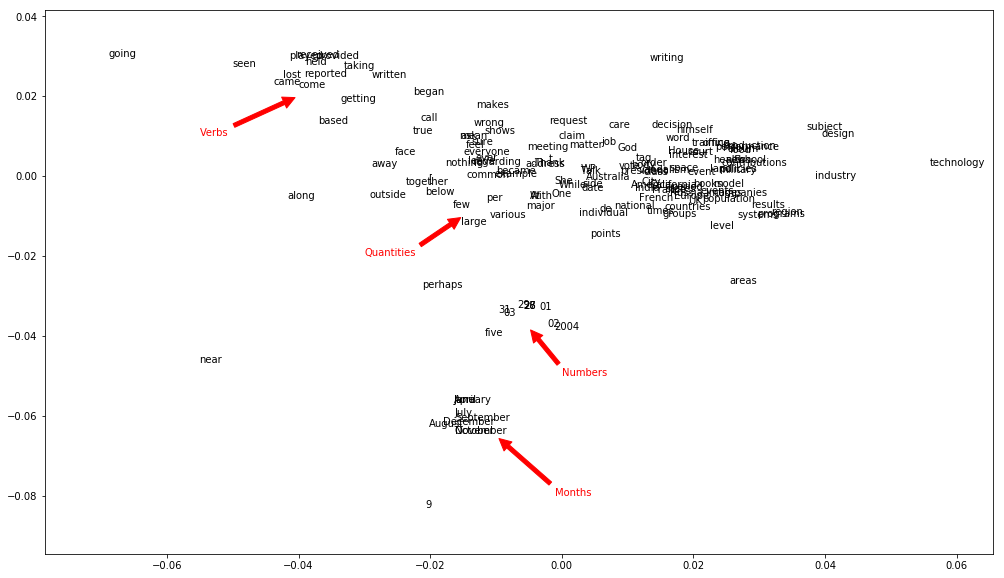

In [5]:
Y = LaplacianEigenmaps(data, k=2, m=14, t='infinity')

fig, ax = plt.subplots(figsize=(17,10))
ax.scatter(Y[0,:], Y[1,:], c='w')

for i, txt in enumerate(vocabulary):
    ax.annotate(txt, (Y[0,i], Y[1,i]), fontsize=10)

ax.annotate('Months', xy=(-0.01, -0.065), xytext=(-0.001, -0.08), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))
ax.annotate('Numbers', xy=(-0.005, -0.038), xytext=(0, -0.05), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))
ax.annotate('Quantities', xy=(-0.015, -0.01), xytext=(-0.03, -0.02), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))
ax.annotate('Verbs', xy=(-0.04, 0.02), xytext=(-0.055, 0.01), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))

plt.show()

Let us zoom in on the dense part of the graph :

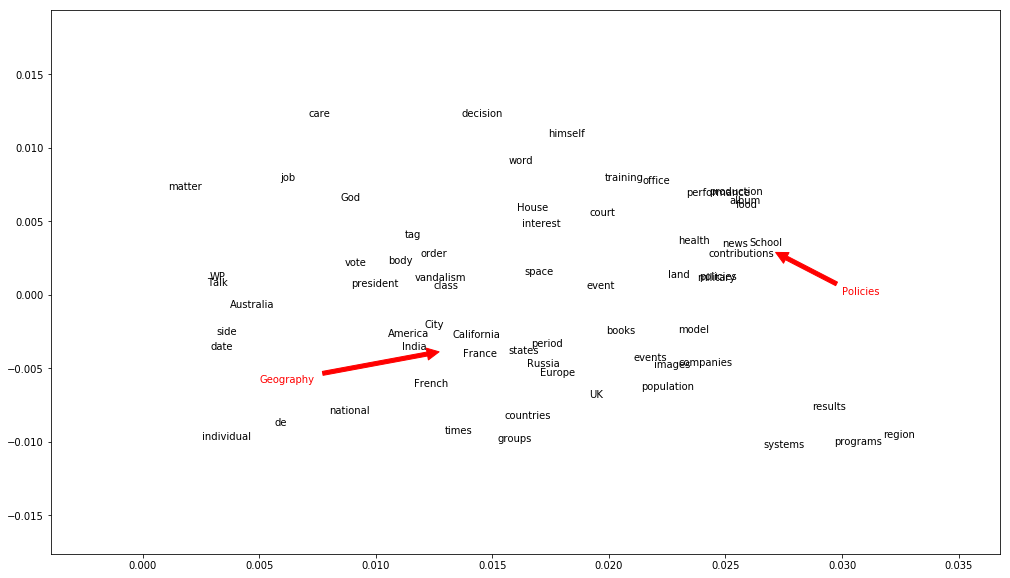

In [6]:
mask = (Y[0,:] > 0) & (Y[0,:] < 0.035) & (Y[1,:] > -0.012) & (Y[1,:] < 0.02)
Z = Y[:,mask]

fig, ax = plt.subplots(figsize=(17,10))
ax.scatter(Z[0,:], Z[1,:], c='w')

for i, txt in enumerate(np.array(vocabulary)[mask]):
    ax.annotate(txt, (Z[0,i], Z[1,i]), fontsize=10)

ax.annotate('Geography', xy=(0.013, -0.0038), xytext=(0.005, -0.006), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))
ax.annotate('Policies', xy=(0.027, 0.003), xytext=(0.030, 0.00), color='r', arrowprops=dict(fc='red', ec='red', shrink=0.05))

plt.show()

## Links with differential geometry through the Laplace-Beltrami operator

Let us show the link between the algorithmic idea and differential geometry.

First, let $f : \mathcal{M} \to \mathbb{R}$ be a twice differentiable mapping defined on the manifold. For any two points $x,z \in \mathcal{M}$ sufficiently close ($\textrm{dist}_\mathcal{M}(x,z)$ is small), one can show that
$$
|f(x) - f(z)| \leq ||\nabla_\mathcal{M}f(x)|| \times \textrm{dist}_\mathcal{M}(x,z) + o(\textrm{dist}_\mathcal{M}(x,z))
$$
This results means that $f$ will preserve locality if $||\nabla_\mathcal{M}f(x)||$ is small.

The idea is therefore to find a mapping $f$ that preserves the most locality on average, _i.e._ f solution to 
$$
\min_{||f||_{L_2} \leq 1} \int_\mathcal{M} ||\nabla_\mathcal{M}f||^2 \quad \quad \quad (2)
$$

Stokes theorem implies that
$$
\int_\mathcal{M} ||\nabla_\mathcal{M}f||^2 = \int_\mathcal{M} \Delta_\mathcal{M}f . f
$$
where $\Delta_\mathcal{M} = - \textrm{div} \nabla_\mathcal{M}$ is the Laplace-Beltrami operator on $\mathcal{M}$.

This implies that $f$ is a solution if it is an eigenfunction of $\Delta_\mathcal{M}$.

In `Belkin, M., & Niyogi, P. (2005, June). Towards a theoretical foundation for Laplacian-based manifold methods. In International Conference on Computational Learning Theory (pp. 486-500). Springer, Berlin, Heidelberg.`, Belkin and Niyogi prove the following theorem, giving a link between the Laplacian $L$ of the nearest neighbors graph and the Laplace-Beltrami operator $\Delta_\mathcal{M}$ :

__Theorem__ \[Belkin,Niyogi,2005\] :

Assume $\mathcal{M}$ is compact and $k$-dimensional. Let $x_1, ..., x_n$ be $n$ points sampled uniformally on $\mathcal{M}$. Put $t_n = n^{-\frac{1}{k+2+\alpha}}$ where $\alpha > 0$. Let $f \in \mathcal{C}^\infty_\mathcal{M}$. Then :

$$
\lim_{n\to\infty} \frac{1}{t_n (4\pi t_n)^{k/2}} L_n^{t_n}f(x) = \frac{1}{\textrm{vol}(\mathcal{M})} \Delta_\mathcal{M}f(x)
$$

where $L_n^{t}f$ is the Laplacian of the graph with weight parameter $t$ :
$$
L_n^{t}f(x) = \frac{1}{n} \sum_{j=1}^n (f(x) - f(x_j)) \exp\left\{-\frac{||x-x_j||^2}{4t}\right\}
$$

This theorem means that the Laplace-Beltrami operator $\Delta_\mathcal{M}$ can be well approximated by the Laplacian of the neighborhood graph with exponentially decaying weights.

It is also possible to prove the convergence of eigenfunctions, showing that the minimization problems $(1)$ (empirical) and $(2)$ (functional) have similar solutions.